# 48479853-MAHESH SAI KANDULA
## Assignment 2 - Deep Learning for Image Classification

### Task 1 - Data exploration and preparation

Loading and checking all the csv files(train,test and devtest)

In [24]:
import pandas as pd

df_train = pd.read_csv("train.csv")

# This is used inorder to understand the structure
print("The columns in train csv file", df_train.columns.tolist())
print("\n Rows of train.csv:")
print(df_train.head())

The columns in train csv file ['path', 'label']

 Rows of train.csv:
                  path  label
0  paper/paper_770.png  paper
1  paper/paper_721.png  paper
2   paper/paper_47.png  paper
3  paper/paper_476.png  paper
4  paper/paper_218.png  paper


In [25]:
df_test = pd.read_csv("test.csv")

# This is used inorder to understand the structure
print("The columns in test csv file", df_test.columns.tolist())
print("\n Rows of test.csv:")
print(df_test.head())

The columns in test csv file ['path', 'label']

 Rows of test.csv:
                        path     label
0        paper/paper_343.png     paper
1          rock/rock_697.png      rock
2        paper/paper_489.png     paper
3  scissors/scissors_764.png  scissors
4  scissors/scissors_251.png  scissors


In [26]:
df_devtest = pd.read_csv("devtest.csv")

# This is used inorder to understand the structure
print("The columns in devtest csv file", df_devtest.columns.tolist())
print("\n Rows of devtest.csv:")
print(df_devtest.head())

The columns in devtest csv file ['path', 'label']

 Rows of devtest.csv:
                        path     label
0          rock/rock_353.png      rock
1  scissors/scissors_211.png  scissors
2          rock/rock_198.png      rock
3   scissors/scissors_37.png  scissors
4          rock/rock_605.png      rock


In [27]:
import cv2
from collections import Counter

# This is used to define the root directory where all the folders of rock,paper and scissors are stored
root_directory = "archive"

# Dictionary of datasets 
datasets = {
    "train": df_train,
    "devtest": df_devtest,
    "test": df_test
}

In [28]:
import matplotlib.pyplot as plt



<--- TRAIN SET --->
-->train, Class: paper, Image: archive/paper/paper_770.png, Shape: (300, 300, 3)


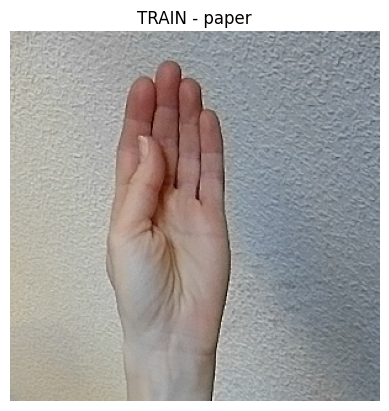

-->train, Class: rock, Image: archive/rock/rock_20.png, Shape: (300, 300, 3)


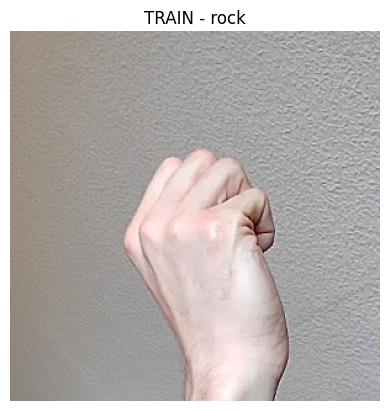

-->train, Class: scissors, Image: archive/scissors/scissors_886.png, Shape: (300, 300, 3)


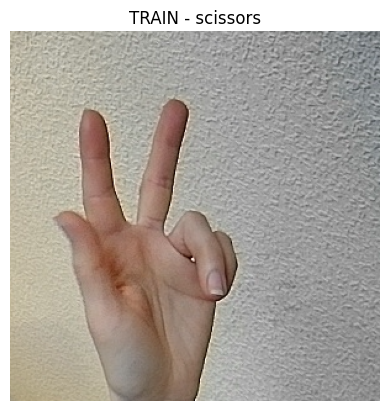


<--- DEVTEST SET --->
-->devtest, Class: rock, Image: archive/rock/rock_353.png, Shape: (300, 300, 3)


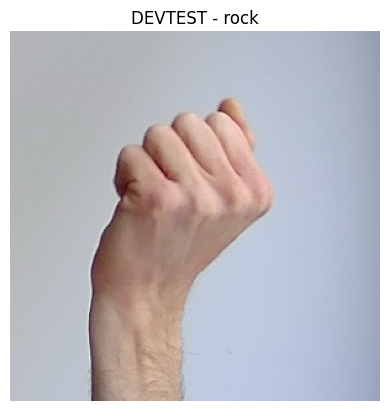

-->devtest, Class: scissors, Image: archive/scissors/scissors_211.png, Shape: (300, 300, 3)


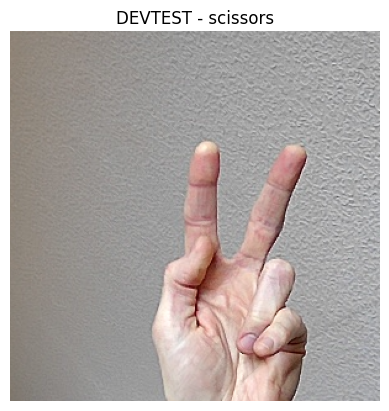

-->devtest, Class: paper, Image: archive/paper/paper_263.png, Shape: (300, 300, 3)


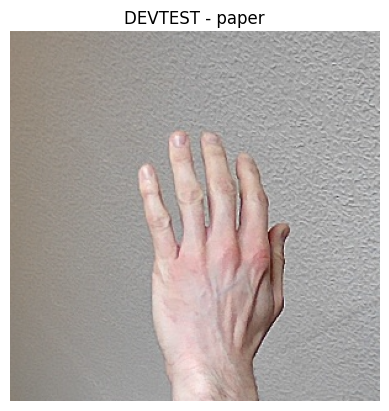


<--- TEST SET --->
-->test, Class: paper, Image: archive/paper/paper_343.png, Shape: (300, 300, 3)


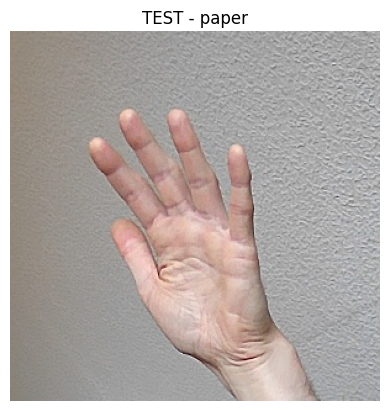

-->test, Class: rock, Image: archive/rock/rock_697.png, Shape: (300, 300, 3)


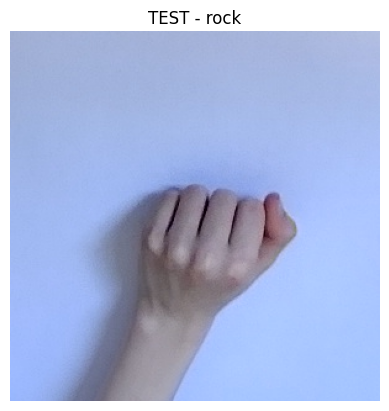

-->test, Class: scissors, Image: archive/scissors/scissors_764.png, Shape: (300, 300, 3)


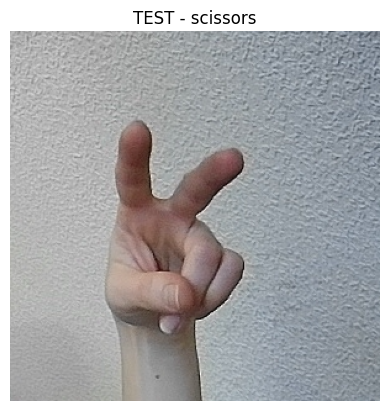


 Summary:

TRAIN SET:
  rock: 2 images (22.22%)
  paper: 6 images (66.67%)
  scissors: 1 images (11.11%)

DEVTEST SET:
  rock: 8 images (57.14%)
  paper: 1 images (7.14%)
  scissors: 5 images (35.71%)

TEST SET:
  rock: 1 images (25.00%)
  paper: 2 images (50.00%)
  scissors: 1 images (25.00%)


In [29]:
# this can be used to store class distribution for each set
#here the initialisation of the dictionary is done to store count of images for each class and dataset
class_counts = {}

# Looping through the each dataset
for name, df in datasets.items():
    print(f"\n<--- {name.upper()} SET --->")
    shown_classes = set()#used to check which classes have already one image displayed
    counts = Counter()#counts how many times each class appears

    #Looping through every row in dataset
    for _, row in df.iterrows():
        label = row['label']#class label
        img_path = f"{root_directory}/{row['path']}"  # Used string formatting

        img = cv2.imread(img_path)#Loading the image
        # if image is succesfully loaded we can print dataset name,class label ,full path of the image and the the shape of the image
        if img is not None:
            if label not in shown_classes:
                print(f"-->{name}, Class: {label}, Image: {img_path}, Shape: {img.shape}")
                shown_classes.add(label)
                #Process to display the image
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(f"{name.upper()} - {label}")
                plt.axis('off')
                plt.show()

                shown_classes.add(label)
        #Handling the error
        else:
            print(f" Unable to load image: {img_path}")

        counts[label] += 1
        if len(shown_classes) == 3:  # Only show one image per class
            break
    #Storing the count for the current dataset in the class_counts dictionary
    class_counts[name] = counts

# Printing the summary of the class distribution
print("\n Summary:")
for name, counts in class_counts.items():
    total = sum(counts.values())
    print(f"\n{name.upper()} SET:")
    #Looping through all the datasets abd prints the number of images abd proportion of the class in the particular dataset.
    for label in ['rock', 'paper', 'scissors']:
        count = counts[label]
        percent = (count / total) * 100
        print(f"  {label}: {count} images ({percent:.2f}%)")


Total number of images are 9 which means 3 for each category in each dataset

Also,Based on the output above my interpreation is that the proportions are not balanced .
because,each class should be having 33.3% approximately inorder to balance but in our case the paper dominates in train dataset,Rock dominates in devtest dataset and Scissors is very much low in the train dataset

This may make the model underperform and get biased and this may be solved by re splitting the images or even by adding more images to the dataset

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image#can be used to open image files

# Defining the image transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),   # Resize to 100x100,making sure all the images are of same size
    transforms.ToTensor()            # Converts image to tensor and used to scale pixel values to 0 to 1)
])

# this class is inherited from torch.utils.data.Dataset and used to load and access the image-label data
class RPSDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(self.data['label'].unique())#List that contains the class names
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}#Mapping the labels and numbers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = f"{self.root_dir}/{self.data.iloc[idx]['path']}"
        image = Image.open(img_path).convert('RGB')  # Opens and converts to RGB
        label = self.class_to_idx[self.data.iloc[idx]['label']]#Converts the label to images
        if self.transform:
            image = self.transform(image)
        return image, label


In [37]:
# Image directory (same as used in earlier code)
image_rootDirectory = "archive"

# assigning the paths to a variable
train_csv = "train.csv"
devtest_csv = "devtest.csv"
test_csv = "test.csv"

# Creating the objects for datsets
train_dataset = RPSDataset(train_csv, image_rootDirectory, transform)
devtest_dataset = RPSDataset(devtest_csv, image_rootDirectory, transform)
test_dataset = RPSDataset(test_csv, image_rootDirectory, transform)

# Creating the dataloaders
#Batch uses a standard 32 samples at a time
#Also shuffle is made true for only training inorder help the model generalize better
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Dataloaders are successfully created!")


Dataloaders are successfully created!
